## ML for Survival of Swainson Thrushs

#### Import libraries

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
import shap
from imblearn.ensemble import BalancedRandomForestClassifier
from matplotlib.patches import Patch
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import plot_tree

#### Load Data and Preprocessing

In [2]:
file_path = "https://raw.githubusercontent.com/sarahvastani/portfolio/refs/heads/main/Survival_of_Migration_Project/Dataset/Dataset1.phiSurvival.20250707.csv"
df = pd.read_csv(file_path)
df

,reference,name_in_vcf,release_site,capture_site,release_year,tag_type,sex_binary,age_release,release_gps.n,release_gps.w,...,range_norm_p9,range_norm_p10,range_norm_releaseDay,range_norm_fall_detectDay1,range_norm_fall_bearing1,range_norm_bodyCondition,ch_10days,ch,phi,phi_binary
0,AH17K18,AH17K18,Pemberton,Pemberton,2019,radio,1,HY,50.353386,-122.832926,...,0.666667,NaN,0.000000,NaN,NaN,0.849981,days_100110000000000000000000000000,100110000000000000000000000000,0.000000e+00,0
1,AH18K02,AH18K02,Pemberton,Pemberton,2019,radio,1,HY,50.353386,-122.832926,...,0.833333,NaN,0.043478,0.250,0.424781,0.674626,days_110000100000000000000000000000,110000100000000000000000000000,1.084520e-38,0
2,AH22K02,AH22K02,Pemberton,Pemberton,2019,radio,1,HY,50.353386,-122.832926,...,0.388889,NaN,0.217391,0.500,0.731704,0.347152,days_101000000000000000000000000000,101000000000000000000000000000,8.884759e-14,0
3,AH22K04,AH22K04_S154_L001,Pemberton,Pemberton,2019,radio,1,HY,50.353386,-122.832926,...,0.444444,NaN,0.217391,NaN,NaN,0.571480,days_100000000000000000000000000000,100000000000000000000000000000,1.285971e-240,0
4,AH22K09,AH22K09,Pemberton,Pemberton,2019,radio,1,HY,50.353386,-122.832926,...,0.444444,NaN,0.217391,0.550,0.836626,0.294291,days_101000000000000000000000000000,101000000000000000000000000000,8.884759e-14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,EH31H02,EH31H02,Pemberton,Pemberton,2023,radio,1,HY,50.220153,-122.884084,...,0.777778,0.375,0.608696,0.600,0.474724,0.468136,days_101001000000000000000000000000,101001000000000000000000000000,0.000000e+00,0
475,EH31H03,EH31H03,Pemberton,Pemberton,2023,radio,1,HY,50.220153,-122.884084,...,0.500000,0.250,0.608696,0.825,0.474724,0.468227,days_101100000000000000000000000000,101100000000000000000000000000,2.362661e-23,0
476,EH31H07,EH31H07,Pemberton,Pemberton,2023,radio,0,HY,50.220153,-122.884084,...,0.555556,0.500,0.608696,0.900,0.474724,0.281292,days_100110000000000000000000000000,100110000000000000000000000000,0.000000e+00,0
477,EH31H08,EH31H08,Pemberton,Pemberton,2023,radio,0,HY,50.220153,-122.884084,...,0.444444,0.250,0.608696,0.425,0.352253,0.513245,days_110100100000000000000000100111,110100100000000000000000100111,1.000000e+00,1


#### Figure S3a: Feature Correlation Matrix

In [47]:
# List of columns to include in the correlation matrix
cols_of_interest = [
    'sex_binary', 'aims_ancestry', 'aims_heterozygosity', 'tarsus.length', 'weight',
    'tail.length', 'wing.cord', 'kipps', 'distal', 'carpal', 'p7', 'p8', 'p9', 'p10',
    'bodyCondition', 'fat.score', 'releaseDay', 'fall_detectDay1', 'fall_bearing1'
]

# Keep only the selected columns (drop any that might be missing)
df_corr = df[cols_of_interest].copy()

# Drop rows with any missing values (or you could use imputation if preferred)
df_corr = df_corr.dropna()

# Compute correlation matrix
corr_matrix = df_corr.corr(numeric_only=True)

# Plot correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            cbar_kws={"shrink": 0.8}, square=True)
plt.title("Correlation Matrix of Selected Features", fontsize=16)
plt.tight_layout()

plt.savefig('FigS3a.png', dpi=300, bbox_inches='tight')  
plt.close()

#### Figure S3b: Percentage of missing values for each feature

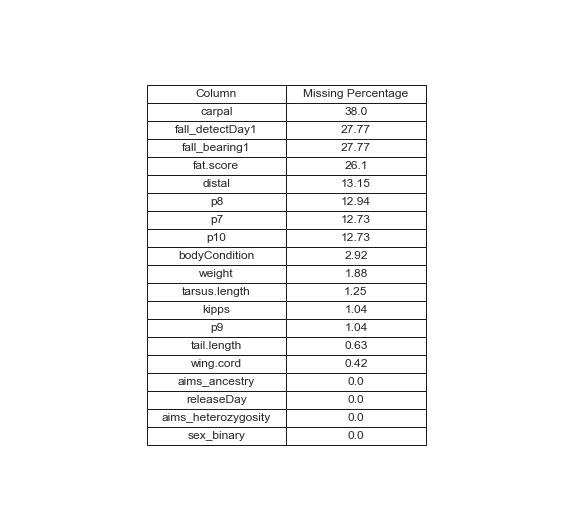

In [62]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, len(missing_df)*0.5))
ax.axis('off')
table = ax.table(
    cellText=missing_df.round(2).values,
    colLabels=missing_df.columns,
    loc='center',
    cellLoc='center'
)
table.scale(0.5, 1.5)
plt.tight_layout()
plt.savefig("FigS3b.png", dpi=300)

#### Figure S4: Distributions of key predictive features used in the analysis

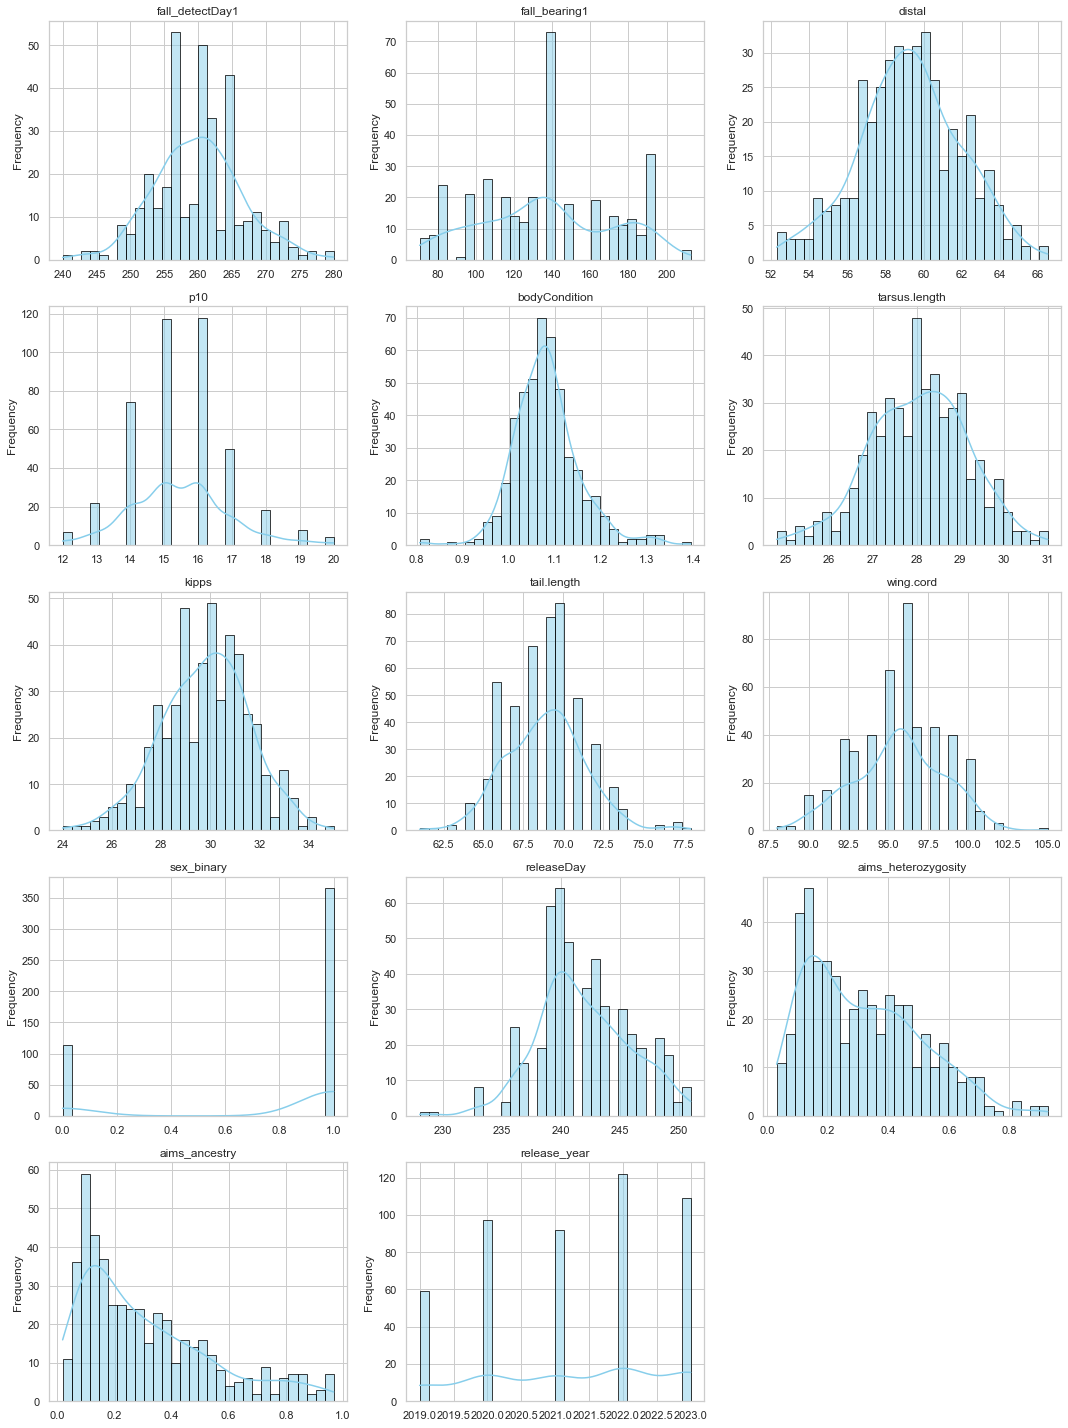

In [63]:
features = ['fall_detectDay1', 'fall_bearing1',
            'distal', 'p10', 'bodyCondition', 'tarsus.length',
            'kipps', 'tail.length', 'wing.cord', 
            'sex_binary', 'releaseDay', 'aims_heterozygosity', 
            'aims_ancestry', 'release_year']

# Set up aesthetics
sns.set(style="whitegrid")
n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    if pd.api.types.is_numeric_dtype(df[feature]):
        sns.histplot(data=df, x=feature, kde=True, ax=ax, bins=30, color='skyblue', edgecolor='black')
        ax.set_title(f'{feature}', fontsize=12)
    else:
        sns.countplot(data=df, x=feature, ax=ax, color='skyblue', edgecolor='black')
        ax.set_title(f'{feature} (categorical)', fontsize=12)
        
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('FigS4.png', dpi=300, bbox_inches='tight')  

#### Model Training

In [29]:
# Feature and label setup
features = ['fall_detectDay1', 'fall_bearing1', 'distal', 'p10', 'bodyCondition',
            'tarsus.length', 'kipps', 'tail.length', 'wing.cord', 
            'sex_binary', 'releaseDay', 'aims_heterozygosity', 
            'aims_ancestry', 'release_year']

X = df[features]
y = df['phi_binary'].astype(int)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=120, 
    random_state=42,
    stratify=y
)


# Pipeline setup
pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('smote', SMOTE(random_state=42)),
    ('brf', BalancedRandomForestClassifier(random_state=42))
])

# Parameter grid
param_grid = {
    'brf__n_estimators': [100, 200, 300],
    'brf__max_depth': [10, 20, None],
    'brf__max_features': ['sqrt', 'log2', None],
    'brf__min_samples_split': [2, 5, 10],
    'brf__min_samples_leaf': [1, 2, 4]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=40,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the model
search.fit(X_train, y_train)
best_model = search.best_estimator_
probs = best_model.predict_proba(X_test)[:, 1]

# Threshold tuning
thresholds = np.linspace(0.4, 0.7, 100)
results = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    report = classification_report(y_test, preds, output_dict=True, zero_division=0)
    results.append({
        'threshold': t,
        'accuracy': report['accuracy'],
        'class0_recall': report['0']['recall'],
        'class1_recall': report['1']['recall'],
        'class0_f1': report['0']['f1-score'],
        'class1_f1': report['1']['f1-score'],
        'macro_f1': (report['0']['f1-score'] + report['1']['f1-score']) / 2
    })

# Optimal threshold
results_df = pd.DataFrame(results)
best_row = results_df.sort_values(by='macro_f1', ascending=False).iloc[0]
best_thresh = best_row['threshold']
final_preds = (probs >= best_thresh).astype(int)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.


#### Figure S1a: Decision Tree Example

In [46]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Extract the fitted BalancedRandomForestClassifier
brf_model = best_model.named_steps['brf']

# Get the first tree estimator
estimator = brf_model.estimators_[0]

plt.figure(figsize=(15, 12))  # Size of the figure in inches
plot_tree(
    estimator,
    feature_names=features,
    class_names=['class 0', 'class 1'],
    filled=True,
    rounded=True,
    fontsize=10
)

# Save the figure as a high-res PNG (300 DPI)
plt.savefig('FigS1a.png', dpi=300, bbox_inches='tight')  
plt.close()


#### Evaluation

In [30]:
print("\n Best Threshold (macro F1):", best_thresh)
print(confusion_matrix(y_test, final_preds))
print(classification_report(y_test, final_preds, zero_division=0))


 Best Threshold (macro F1): 0.6393939393939394
[[68 15]
 [19 18]]
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        83
           1       0.55      0.49      0.51        37

    accuracy                           0.72       120
   macro avg       0.66      0.65      0.66       120
weighted avg       0.71      0.72      0.71       120



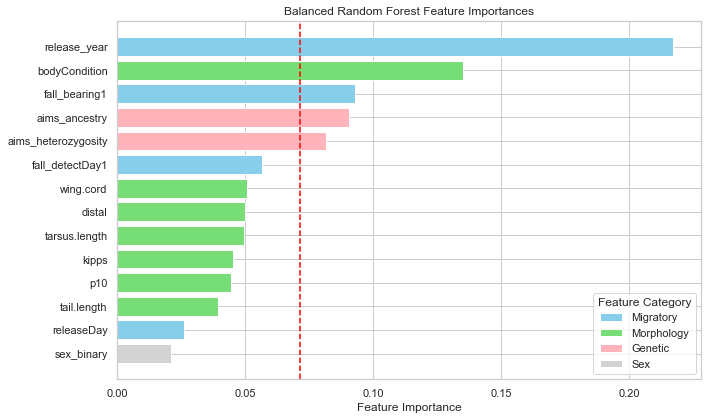

In [31]:
feature_categories = {
    'fall_detectDay1': 'Migratory',
    'fall_bearing1': 'Migratory',
    'releaseDay': 'Migratory',
    'release_year': 'Migratory',  
    'distal': 'Morphology',
    'p10': 'Morphology',
    'bodyCondition': 'Morphology',
    'tarsus.length': 'Morphology',
    'kipps': 'Morphology',
    'tail.length': 'Morphology',
    'wing.cord': 'Morphology',
    'aims_heterozygosity': 'Genetic',
    'aims_ancestry': 'Genetic',
    'sex_binary': 'Sex'
}

category_colors = {
    'Migratory': '#87ceeb',  # Light blue
    'Morphology': '#77dd77', # Light green
    'Genetic': '#ffb3ba',    # Light pink
    'Sex': '#d3d3d3'         # Light gray
}

# Get feature names and importances
feature_names = X_train.columns
importances = best_model.named_steps['brf'].feature_importances_

# Clean feature names for category lookup
clean_names = [f.replace('norm_', '') for f in feature_names]

# Assign categories based on your mapping
categories = [feature_categories.get(name, 'Other') for name in clean_names]

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances,
    'Category': categories
}).sort_values(by='Importance', ascending=False)

# Assign colors based on category
colors = importance_df['Category'].map(category_colors).fillna('gray')

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(
    importance_df['Feature'],
    importance_df['Importance'],
    color=colors
)
plt.gca().invert_yaxis()
plt.axvline(x=1/len(feature_names), color='red', linestyle='--', label='1 / num_features')

# Create legend for only used categories
used_categories = importance_df['Category'].unique()
legend_elements = [
    Patch(facecolor=category_colors.get(cat, 'gray'), label=cat)
    for cat in used_categories
]

plt.legend(handles=legend_elements, title="Feature Category")
plt.xlabel("Feature Importance")
plt.title("Balanced Random Forest Feature Importances")
plt.tight_layout()


# 🔽 Save to PDF
plt.savefig("feature_importances.pdf", format="pdf")
plt.show()

In [64]:
from itertools import combinations
from sklearn.metrics import f1_score
import numpy as np

np.random.seed(1)

# Get the trained model from your pipeline (after imputation & SMOTE)
rf_model = best_model.named_steps['brf']

# Get the full pipeline transform on X_test (impute, SMOTE doesn't apply to test)
X_test_imputed = best_model.named_steps['imputer'].transform(X_test)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=features)

# Baseline F1 macro score using optimal threshold
baseline_probs = rf_model.predict_proba(X_test_imputed.values)[:, 1]
baseline_preds = (baseline_probs >= best_thresh).astype(int)
baseline_score = f1_score(y_test, baseline_preds, average='macro')

# All possible feature pairs
feature_pairs = list(combinations(features, 2))
n_pairs = len(feature_pairs)
baseline_interaction = 0.1  # baseline for filtering

# Store interaction drops
interaction_scores = []

for feat1, feat2 in feature_pairs:
    X_test_permuted = X_test_imputed.copy()
    # Jointly permute both features
    perm = np.random.permutation(len(X_test_permuted))
    X_test_permuted[[feat1, feat2]] = X_test_permuted[[feat1, feat2]].iloc[perm].values

    perm_probs = rf_model.predict_proba(X_test_permuted.values)[:, 1]
    perm_preds = (perm_probs >= best_thresh).astype(int)
    perm_score = f1_score(y_test, perm_preds, average='macro')

    drop = baseline_score - perm_score
    interaction_scores.append(((feat1, feat2), drop))

# Sort and filter based on the baseline
important_interactions = [((f1, f2), score) for (f1, f2), score in interaction_scores if score > baseline_interaction]
important_interactions = sorted(important_interactions, key=lambda x: x[1], reverse=True)

# Display top interactions
for (f1, f2), score in important_interactions:
    print(f"{f1} + {f2}: ΔF1 = {score:.4f}")


bodyCondition + release_year: ΔF1 = 0.2275
aims_ancestry + release_year: ΔF1 = 0.1696
fall_bearing1 + tarsus.length: ΔF1 = 0.1644
fall_bearing1 + distal: ΔF1 = 0.1532
distal + bodyCondition: ΔF1 = 0.1530
kipps + release_year: ΔF1 = 0.1472
distal + release_year: ΔF1 = 0.1460
tarsus.length + release_year: ΔF1 = 0.1460
fall_bearing1 + sex_binary: ΔF1 = 0.1456
releaseDay + release_year: ΔF1 = 0.1407
fall_bearing1 + bodyCondition: ΔF1 = 0.1378
aims_heterozygosity + release_year: ΔF1 = 0.1356
sex_binary + release_year: ΔF1 = 0.1350
fall_detectDay1 + release_year: ΔF1 = 0.1319
bodyCondition + kipps: ΔF1 = 0.1291
fall_detectDay1 + aims_heterozygosity: ΔF1 = 0.1238
kipps + aims_ancestry: ΔF1 = 0.1199
fall_bearing1 + release_year: ΔF1 = 0.1179
tail.length + release_year: ΔF1 = 0.1179
distal + tarsus.length: ΔF1 = 0.1169
bodyCondition + aims_heterozygosity: ΔF1 = 0.1169
fall_bearing1 + tail.length: ΔF1 = 0.1135
fall_detectDay1 + bodyCondition: ΔF1 = 0.1119
sex_binary + aims_heterozygosity: ΔF1 = 

In [43]:
feature_pairs = list(combinations(features, 2))
n_pairs = len(feature_pairs)
baseline_interaction = 1 / n_pairs
baseline_interaction

0.01098901098901099

In [41]:
import pandas as pd

# Convert to DataFrame
df_interactions = pd.DataFrame([
    {'Feature 1': f1, 'Feature 2': f2, 'Delta F1': score}
    for (f1, f2), score in important_interactions
])

# Save to CSV
df_interactions.to_csv('important_pairwise_interactions.csv', index=False)


<Figure size 432x288 with 0 Axes>

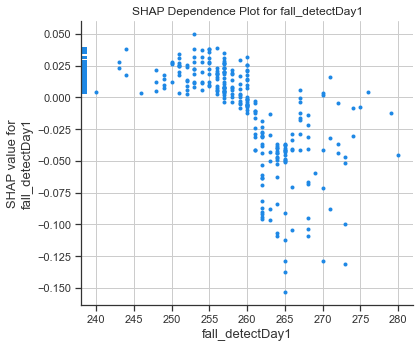

<Figure size 432x288 with 0 Axes>

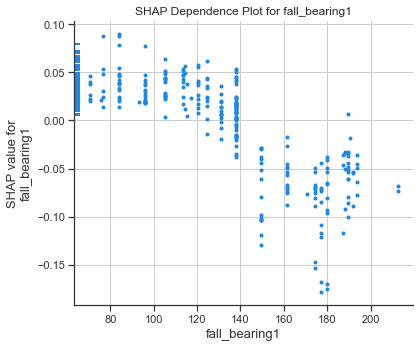

<Figure size 432x288 with 0 Axes>

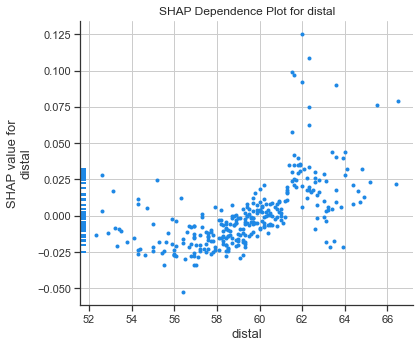

<Figure size 432x288 with 0 Axes>

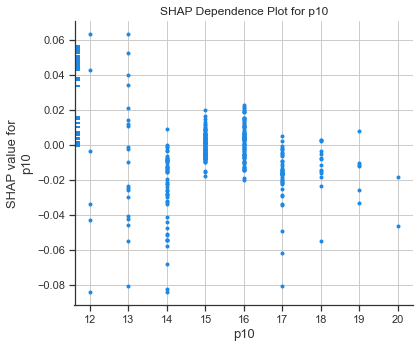

<Figure size 432x288 with 0 Axes>

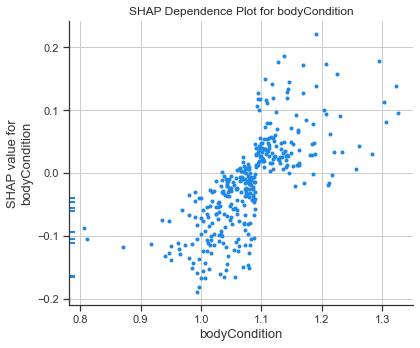

<Figure size 432x288 with 0 Axes>

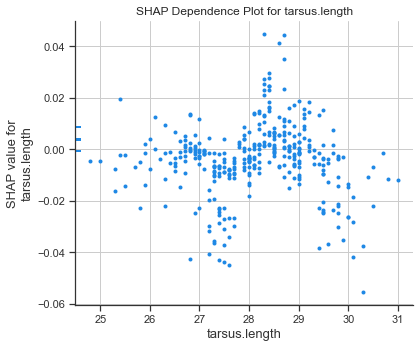

<Figure size 432x288 with 0 Axes>

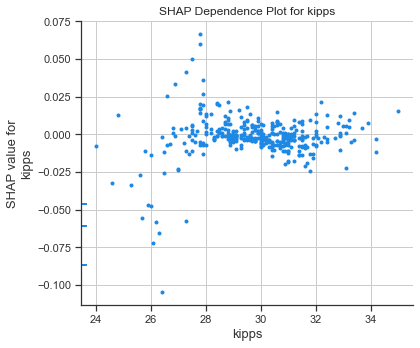

<Figure size 432x288 with 0 Axes>

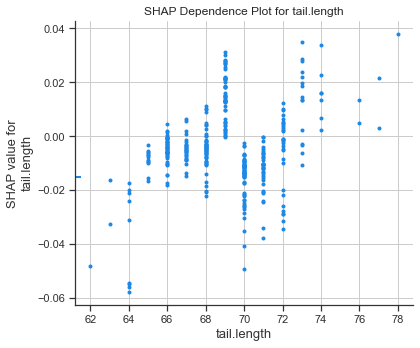

<Figure size 432x288 with 0 Axes>

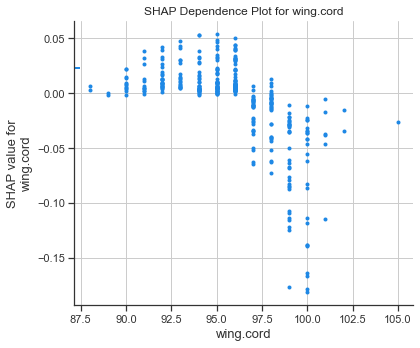

<Figure size 432x288 with 0 Axes>

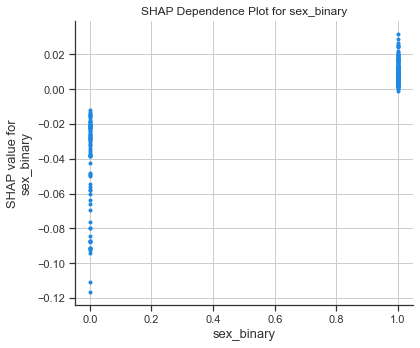

<Figure size 432x288 with 0 Axes>

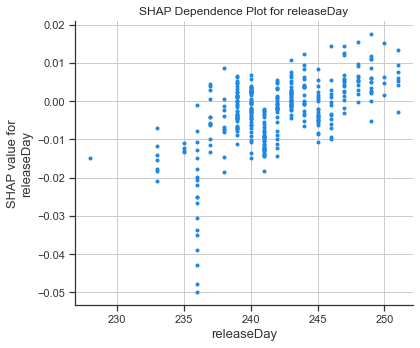

<Figure size 432x288 with 0 Axes>

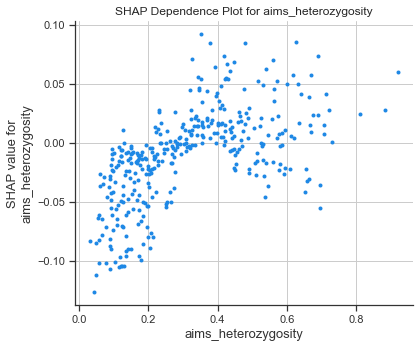

<Figure size 432x288 with 0 Axes>

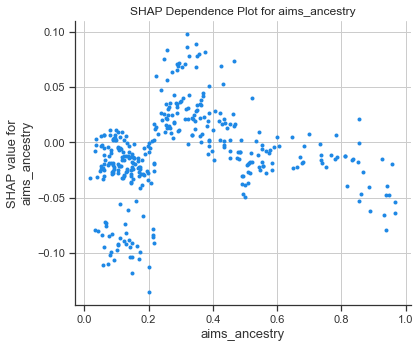

<Figure size 432x288 with 0 Axes>

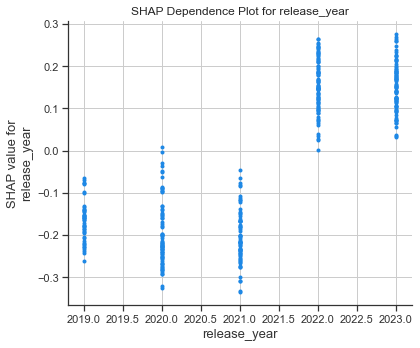

In [32]:
# Get the trained BRF model
model = best_model.named_steps['brf']

# Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# For binary classification, shap_values is a list (one array per class)
# Use the SHAP values for the positive class (index 1)
shap_vals_class1 = shap_values[1]

# Loop through each feature to make 1D dependence plots
for i, feature in enumerate(X_train.columns):
    plt.figure(figsize=(6, 4))
    shap.dependence_plot(
        ind=feature,
        shap_values=shap_vals_class1,
        features=X_train,
        interaction_index=None,  # Disable coloring by another feature
        show=False  # Prevent auto display so we can customize layout
    )
    plt.title(f"SHAP Dependence Plot for {feature}")
    plt.tight_layout()
    plt.show()
